### Sequence	Labelling	Model

In [1]:
from lazy import lazy
import gzip
import os
import csv
import numpy as np
from itertools import islice

In [2]:
class OcrDataset:
    """
    Dataset of handwritten words collected by Rob Kassel at the MIT Spoken
    Language Systems Group. Each example contains the normalized letters of the
    word, padded to the maximum word length. Only contains lower case letter,
    capitalized letters were removed.
    From: http://ai.stanford.edu/~btaskar/ocr/
    """
    URL = 'http://ai.stanford.edu/~btaskar/ocr/letter.data.gz'
    
    def __init__(self, cache_dir):
        path, _ = urllib.request.urlretrieve(type(self).URL, cache_dir)
        lines = self._read(path)
        data, target = self._parse(lines)
        self.data, self.target = self._pad(data, target)    
        
    @staticmethod
    def _read(filepath):
        with gzip.open(filepath, 'rt') as file_:
            reader = csv.reader(file_, delimiter='\t')
            lines = list(reader)
            return lines

    @staticmethod
    def _parse(lines):
        lines = sorted(lines, key=lambda x: int(x[0]))
        data, target = [], []
        next_ = None
        for line in lines:
            if not next_:
                data.append([])
                target.append([])
            else:
                assert next_ == int(line[0])
            next_ = int(line[2]) if int(line[2]) > -1 else None
            pixels = np.array([int(x) for x in line[6:134]])
            pixels = pixels.reshape((16, 8))
            data[-1].append(pixels)
            target[-1].append(line[1])
        return data, target
    
    @staticmethod
    def _pad(data, target):
        max_length = max(len(x) for x in target)
        padding = np.zeros((16, 8))
        data = [x + ([padding] * (max_length - len(x))) for x in data]
        target = [x + ([''] * (max_length - len(x))) for x in target]
        return np.array(data), np.array(target)

In [3]:
class SequenceLabellingModel:
    
    def __init__(self, params):
        self.create_placeholders()
        self.params = params
        self.prediction
        self.summary
        self.cost
        self.error
        self.optimize
        self.global_step = 0
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    def create_placeholders(self):
        with tf.name_scope("placeholders"):
            self.data = tf.placeholder(tf.float32, [None, params.length, params.image_size])
            self.target = tf.placeholder(tf.float32, [None, params.length, params.num_classes])
        
    @lazy
    def length(self):
        with tf.name_scope("length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), axis=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
            return length
    
    @lazy
    def prediction(self):
        with tf.name_scope("prediction"):
            output, _ = tf.nn.dynamic_rnn(
                tf.contrib.rnn.GRUCell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length,
            )
            # Softmax layer.
            max_length = int(self.target.get_shape()[1])
            num_classes = int(self.target.get_shape()[2])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            # Flatten to apply same weights to all time steps.
            output = tf.reshape(output, [-1, self.params.rnn_hidden])
            prediction = tf.nn.softmax(tf.matmul(output, weight) + bias)
            prediction = tf.reshape(prediction, [-1, max_length, num_classes])
            return prediction

    @lazy
    def cost(self):
        with tf.name_scope("cost"):
            # Compute cross entropy for each frame.
            cross_entropy = self.target * tf.log(self.prediction)
            cross_entropy = -tf.reduce_sum(cross_entropy, reduction_indices=2)
            mask = tf.sign(tf.reduce_max(tf.abs(self.target), reduction_indices=2))
            cross_entropy *= mask
            # Average over actual sequence lengths.
            cross_entropy = tf.reduce_sum(cross_entropy, reduction_indices=1)
            cross_entropy /= tf.cast(self.length, tf.float32)
            return tf.reduce_mean(cross_entropy)

    @lazy
    def summary(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            return tf.summary.merge_all()
            
    @lazy    
    def error(self):
        with tf.name_scope("error"):
            mistakes = tf.not_equal(
                tf.argmax(self.target, 2), tf.argmax(self.prediction, 2))
            mistakes = tf.cast(mistakes, tf.float32)
            mask = tf.sign(tf.reduce_max(tf.abs(self.target), reduction_indices=2))
            mistakes *= mask
            # Average over actual sequence lengths.
            mistakes = tf.reduce_sum(mistakes, reduction_indices=1)
            mistakes /= tf.cast(self.length, tf.float32)
            return tf.reduce_mean(mistakes)
    
    @lazy
    def optimize(self):
        with tf.name_scope("optimize"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
            return optimize
    
    def train(self, batches):
        saver = tf.train.Saver()
        if os.path.isdir('./saved/'):
            saver.restore(self.sess, tf.train.latest_checkpoint('./saved/'))
        summary_writer = tf.summary.FileWriter('graphs/run{}'.format(self.global_step), self.sess.graph)
        self.global_step += 1
        for index, batch in enumerate(batches):
            feed = {model.data: batch[0], model.target: batch[1]}
            error, _, summary_str = self.sess.run([model.error, model.optimize, model.summary], feed)
            print('{}: {:3.1f}%'.format(index + 1, 100 * error))
            if index % 1 == 0:
                summary_writer.add_summary(summary_str, index)
        summary_writer.flush()
        saver.save(self.sess, 'saved/my_test_model',global_step=index)
    
#     @lazy
#     def predict_modified(self):
#         data_mask = tf.cast(self.data, tf.bool)
#         empty_mask = tf.reduce_any(data_mask, axis=2)
#         bin_pred = tf.argmax(self.target, axis=2)
#         return tf.casempty_mask * bin_pred
# #         return tf.boolean_mask(empty_mask, bin_pred)
        
    def predict(self, data):
        return self.sess.run([self.prediction], {self.data: data})
        
    def close(self):
        tf.reset_default_graph()
        self.session.close()

In [4]:
from attrdict import AttrDict
import random
import tensorflow as tf
import urllib.request

In [5]:
!! mkdir ocr_dataset

[]

In [6]:
!! rm -rf graphs/

[]

In [7]:
!! rm -rf saved/

[]

In [8]:
params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=300,
    optimizer=tf.train.RMSPropOptimizer(0.002),
    gradient_clipping=5,
    batch_size=10,
    epochs=20,
    epoch_size=50,
)

def get_dataset():
    dataset = OcrDataset('ocr_dataset/ocr')
    # Flatten images into vectors.
    dataset.data = dataset.data.reshape(dataset.data.shape[:2] + (-1,))
    # One-hot encode targets.
    target = np.zeros(dataset.target.shape + (26,))
    for index, letter in np.ndenumerate(dataset.target):
        if letter:
            target[index][ord(letter) - ord('a')] = 1
    dataset.target = target
    # Shuffle order of examples.
    order = np.random.permutation(len(dataset.data))
    dataset.data = dataset.data[order]
    dataset.target = dataset.target[order]
    return dataset

In [9]:
import matplotlib.pyplot as plt
import string

def plot_word(x, y):
    n_letters = x.shape[0]
    plt.figure(1, figsize=(90, 10))

    for i, (letter_img, one_hot_char) in enumerate(zip(x, y)):
        c_ind = np.argmax(one_hot_char)
        let = string.ascii_lowercase[c_ind] if any(one_hot_char) else '_'
        plt.subplot(1, n_letters, i+1)
        plt.title('letter: {}'.format(let), fontsize=60)
        plt.imshow(letter_img.reshape(16, 8), cmap='gray_r')
    plt.show()

In [10]:
def batch_gen(data, target, batch_size):
    data_it = iter(data)
    target_it = iter(target)
    
    data_batch, target_batch = list(islice(data_it, batch_size)) , list(islice(target_it, batch_size))
    
    while data_batch and target_batch:
        yield np.array(data_batch), np.array(target_batch)
        data_batch, target_batch = list(islice(data_it, batch_size)) , list(islice(target_it, batch_size))

In [11]:
dataset = get_dataset()

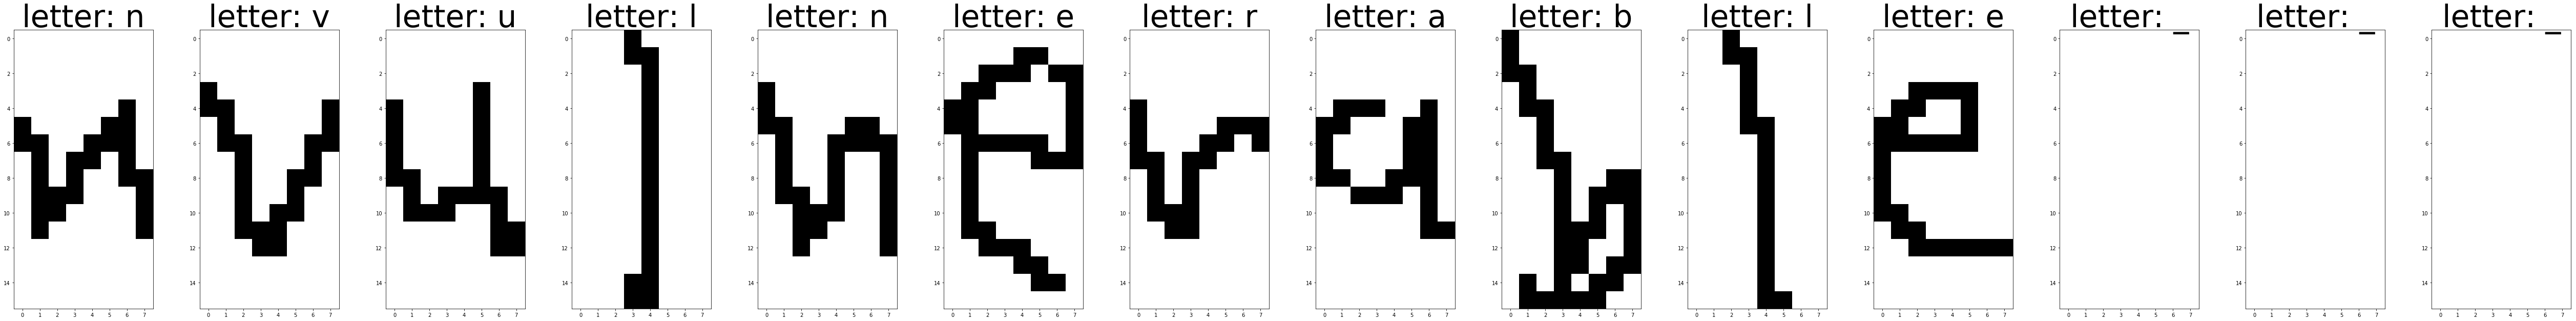

In [12]:
x = dataset.data[1]
y = dataset.target[1]
plot_word(x, y)

In [13]:
# Split into training and test data.
split = int(0.66 * len(dataset.data))

# train_dataset = dataset[:split]
# train_data, test_data = dataset.data[:split], dataset.data[split:]
train_data, train_target = dataset.data[:split], dataset.target[:split]
test_data, test_target = dataset.data[split:], dataset.target[split:]

# Compute graph.
_, params.length, params.image_size = train_data.shape
params.num_classes = train_target.shape[2]

# with tf.Graph().as_default():
# with tf.Graph() as g:
model = SequenceLabellingModel(params)

In [14]:
batches = batch_gen(train_data, train_target, batch_size=10)
model.train(batches)

1: 98.6%
2: 93.3%
3: 93.9%
4: 98.0%
5: 96.9%
6: 98.0%
7: 96.7%
8: 93.1%
9: 96.7%
10: 98.3%
11: 82.4%
12: 97.9%
13: 91.7%
14: 95.4%
15: 92.0%
16: 94.4%
17: 87.4%
18: 95.7%
19: 87.3%
20: 96.4%
21: 89.1%
22: 86.1%
23: 91.7%
24: 92.2%
25: 92.1%
26: 89.3%
27: 86.8%
28: 79.9%
29: 94.7%
30: 91.8%
31: 82.4%
32: 81.5%
33: 90.4%
34: 83.7%
35: 93.0%
36: 88.7%
37: 92.6%
38: 94.7%
39: 92.6%
40: 85.0%
41: 94.8%
42: 97.6%
43: 78.1%
44: 85.0%
45: 95.9%
46: 90.4%
47: 91.7%
48: 90.1%
49: 81.6%
50: 87.1%
51: 98.6%
52: 92.7%
53: 90.4%
54: 89.4%
55: 92.7%
56: 83.7%
57: 88.2%
58: 92.5%
59: 80.7%
60: 93.7%
61: 91.5%
62: 91.1%
63: 95.7%
64: 87.3%
65: 81.6%
66: 82.5%
67: 88.2%
68: 91.5%
69: 95.8%
70: 85.8%
71: 92.7%
72: 82.4%
73: 86.9%
74: 90.9%
75: 85.7%
76: 90.6%
77: 82.0%
78: 77.7%
79: 71.6%
80: 90.9%
81: 79.9%
82: 80.2%
83: 77.1%
84: 86.0%
85: 78.9%
86: 82.2%
87: 78.0%
88: 80.6%
89: 87.0%
90: 85.0%
91: 87.8%
92: 86.4%
93: 87.0%
94: 81.4%
95: 79.9%
96: 74.2%
97: 74.8%
98: 79.4%
99: 79.6%
100: 81.7%
101: 77.

In [15]:
# test_data.shape

(2339, 14, 128)

In [26]:
# with tf.Session() as sess:
#     p = tf.placeholder(dtype=tf.int32, shape=test_data.shape)
#     d = tf.reduce_max(p, axis=2)
#     res = sess.run(d, feed_dict={p:test_data})

In [28]:
# res[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

In [16]:
predicted = model.predict(test_data)[0]

In [17]:
predicted.shape

(2339, 14, 26)

In [18]:
test_target.shape

(2339, 14, 26)

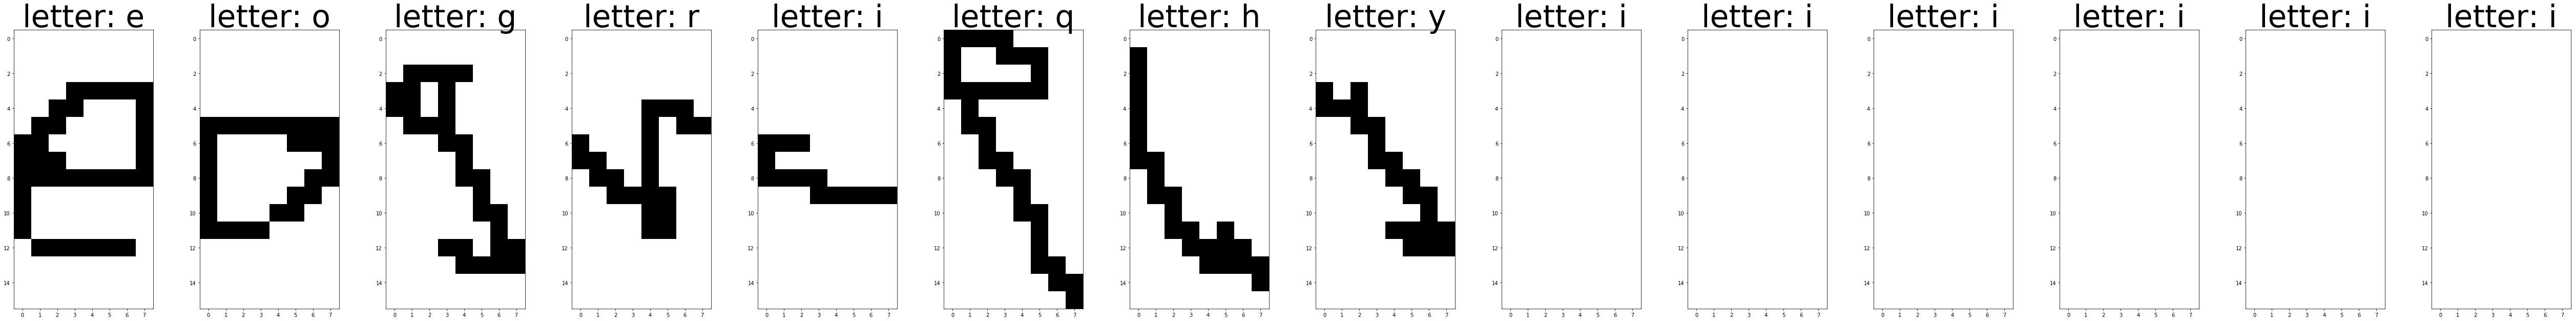

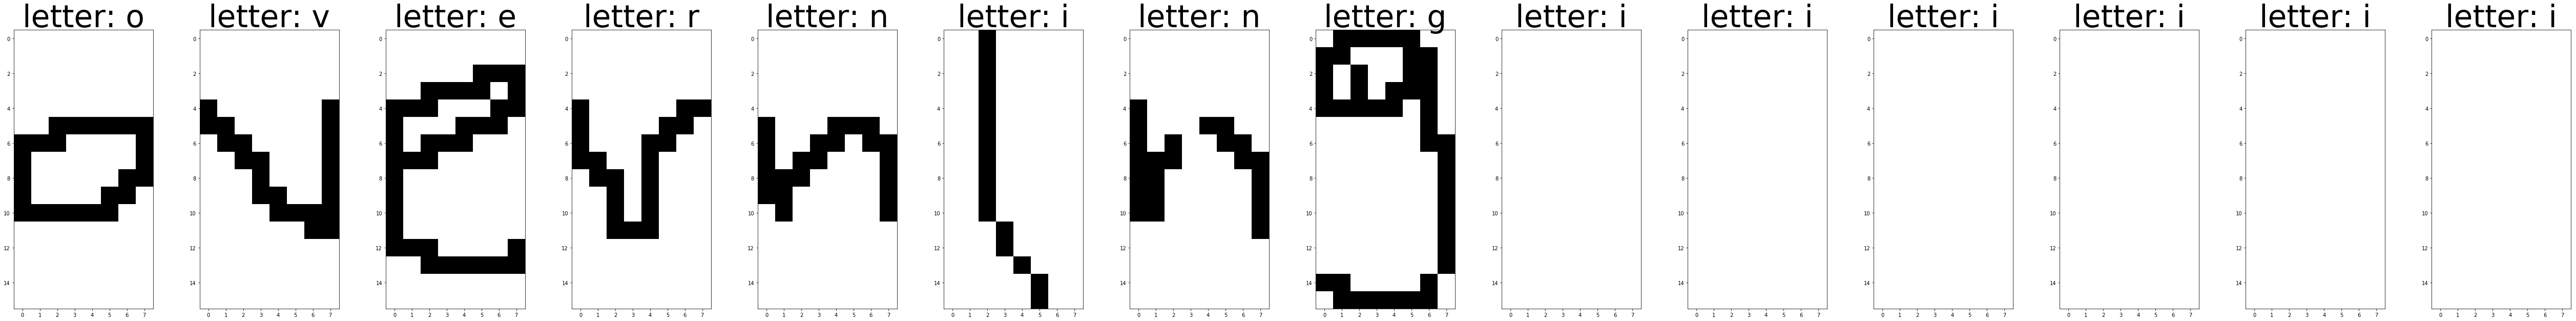

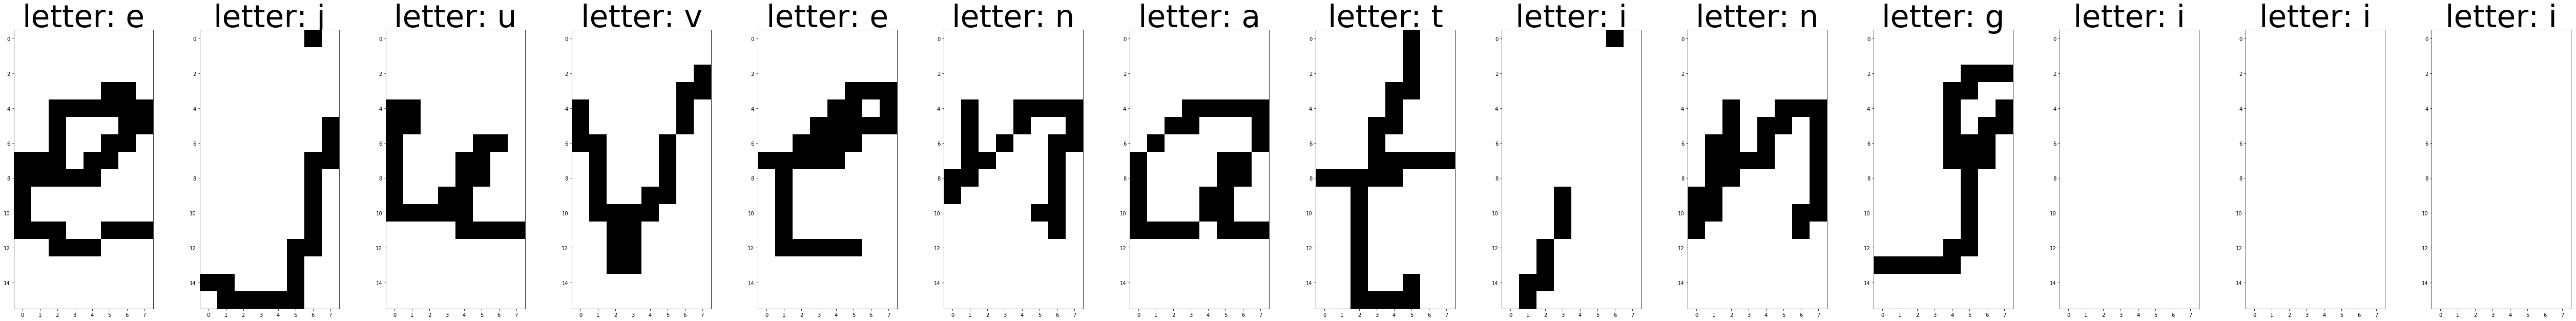

In [19]:
for i, (td, pred) in enumerate(zip(test_data, predicted)):
    plot_word(td, pred)
    if i >= 2:
        break

In [20]:
def targ_to_labels(targ):
    bin_targ = np.argmax(targ, axis=2)
    return bin_targ

In [21]:
test_target_lab = targ_to_labels(test_target)
predicted_lab = targ_to_labels(predicted)

In [22]:
from sklearn.metrics import classification_report, accuracy_score

In [23]:
accuracy_score(test_target_lab.reshape(-1), predicted_lab.reshape(-1))

0.46503389726989558

In [24]:
print(classification_report(predicted_lab.reshape(-1), test_target_lab.reshape(-1)))

             precision    recall  f1-score   support

          0       0.06      0.86      0.12      1219
          1       0.88      0.90      0.89       449
          2       0.79      0.92      0.85       631
          3       0.95      0.68      0.79       667
          4       0.88      0.81      0.85      1860
          5       0.71      0.87      0.78       259
          6       0.90      0.88      0.89       838
          7       0.86      0.86      0.86       288
          8       0.95      0.09      0.16     16805
          9       0.63      0.95      0.76        39
         10       0.71      0.86      0.78       258
         11       0.89      0.91      0.90      1014
         12       0.87      0.94      0.90       537
         13       0.90      0.88      0.89      1747
         14       0.94      0.91      0.92      1376
         15       0.88      0.86      0.87       483
         16       0.58      0.91      0.71        78
         17       0.86      0.76      0.81   

### Bidirectional	RNNs

#### How can we implement bidirectional RNNs in TensorFlow?

 There is actually an
implementation available with  `tf.model.rnn.bidirectional_rnn` .

In [ ]:
@lazy_property
def prediction(self):
    output = self._bidirectional_rnn(self.data, self.length)
    num_classes = int(self.target.get_shape()[2])
    prediction = self._shared_softmax(output, num_classes)
    return prediction

Here	somes	the	interesting	part,	the	implementation	of	bidirectional	RNNs.	As	you	can
see,	we	have	create	two	RNNs	using	 `tf.nn.dynamic_rnn` .	The	forward	network	should	look
familiar	while	the	backward	network	is	new.
Instead	of	just	feeding	in	the	data	into	the	backward	RNN,	we	first	reverse	thesequences.	This	is	easier	than	implementing	a	new	RNN	operation	that	would	go
backwards.	TensorFlow	helps	us	with	with	the	 `tf.reverse_sequence()` 	functions	that	takes	care
of	only	reversing	the	used	frames	up	to	 `sequence_length` .

In [ ]:
def _bidirectional_rnn(self, data, length):
    length_64 = tf.cast(length, tf.int64)
    forward, _ = tf.nn.dynamic_rnn(
        cell=self.params.rnn_cell(self.params.rnn_hidden),
        inputs=data,
        dtype=tf.float32,
        sequence_length=length,
        scope='rnn-forward')
    backward, _ = tf.nn.dynamic_rnn(
        cell=self.params.rnn_cell(self.params.rnn_hidden),
        inputs=tf.reverse_sequence(data, length_64, seq_dim=1),
        dtype=tf.float32,
        sequence_length=self.length,
        scope='rnn-backward')
    backward = tf.reverse_sequence(backward, length_64, seq_dim=1)
    output = tf.concat(2, [forward, backward])
    return output

The	 `_shared_softmax()` 	function	above	is	easy;	we	already	had	the	code	in	the	prediction
property	before.	The	difference	is	that	this	time,	we	infer	the	input	size	from	the	 data 	tensor
that	gets	passed	into	the	function.	This	way,	we	can	reuse	the	function	for	other
architectures	if	needed.	Then	we	use	the	same	flattening	trick	to	share	the	same	softmax
layer	accross	all	time	steps.

In [31]:
def _shared_softmax(self, data, out_size):
    max_length = int(data.get_shape()[1])
    in_size = int(data.get_shape()[2])
    weight = tf.Variable(tf.truncated_normal(
        [in_size, out_size], stddev=0.01))
    bias = tf.Variable(tf.constant(0.1, shape=[out_size]))
    # Flatten to apply same weights to all time steps.
    flat = tf.reshape(data, [-1, in_size])
    output = tf.nn.softmax(tf.matmul(flat, weight) + bias)
    output = tf.reshape(output, [-1, max_length, out_size])
    return output